# Does the Federal Government Close for Forecasted Snow or the Hype for Snow? 

The Office of Personnel Management within the federal government has the [almighty power](https://www.opm.gov/policy-data-oversight/snow-dismissal-procedures/current-status/) of declaring snow days. **Do they base this decision entirely on weather forecasts, or do they fall victim to the hype that surrounds possible snow days?**

To answer this question, I gathered every single snow day OPM has declared (scraper [here](https://github.com/josephofiowa/zenzic/blob/master/federal-snow/fedsnow-scraper.py)). I also used the Dark Sky API to gather historical weather forecasts -- not historical *actual* weather, but what forecast was available to OPM at the time of their decision ([script](https://darksky.net/dev/) and [data](https://github.com/josephofiowa/zenzic/blob/master/federal-snow/forecasts.csv)). Finally, I downloaded the last five years of [Google Trends](https://trends.google.com/trends/explore?geo=US-DC&q=snow) search data for searches of "snow" within DC ([data](https://github.com/josephofiowa/zenzic/blob/master/federal-snow/google-trends-dc-snow.csv)).

I hope you enjoy the analysis that follows just as much as I did completing it. It's commented and everything is open source.

Keep up with the latest data science trends, cool analyses like this, and more via [Entropy](https://www.josephofiowa.com/entropy/).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

## OPM Federal Closure Data

Read in the data, clean it a bit, make a few plots.

In [3]:
opm = pd.read_csv('./opm_snow_data.csv')

In [4]:
# rid unnecessary column...
opm.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# check 'er out
opm.head()

,year,date,notice
0,2017,"March 15, 2017",Open
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...


### Clean the date values

In [6]:
# I remember scraping a messy date column (hence the "year" and "date" columns). Indeed, this will need some cleaning.
opm.date

0          March 15, 2017
1          March 14, 2017
2          March 16, 2016
3       February 16, 2016
4        February 9, 2016
5        January 29, 2016
6        January 28, 2016
7        January 27, 2016
8        January 26, 2016
9        January 25, 2016
10       January 22, 2016
11       January 22, 2016
12          March 6, 2015
13          March 5, 2015
14          March 3, 2015
15          March 2, 2015
16      February 26, 2015
17      February 18, 2015
18      February 17, 2015
19       January 27, 2015
20       January 26, 2015
21       January 21, 2015
22       January 14, 2015
23       January 12, 2015
24        January 6, 2015
25         March 17, 2014
26          March 4, 2014
27          March 3, 2014
28      February 26, 2014
29      February 14, 2014
              ...        
117          September 18
118              March 19
119              March 18
120           February 28
121           February 27
122           February 20
123           February 19
124         

In [7]:
# function to clean dates
# if there's a comma, convert to datetime and return
# if there's not a comma, grab month/day from something like 'January 27 (PM)' and concatenate with year. Return result
def convert_date(year, date):
    if ',' in date:
        return(pd.to_datetime(date))
    else:
        item = date.split(' (')[0]
        return(pd.to_datetime(str(item) + ', ' + str(year)))

In [8]:
# use function
opm['clean_date'] = opm.apply(lambda row: convert_date(row['year'], row['date']), axis=1)

In [9]:
# check...
print(opm.clean_date.min())
print(opm.clean_date.max())

1998-01-15 00:00:00
2026-12-25 20:03:00


In [10]:
# 2026?!
opm[opm.clean_date > '2017']

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15 00:00:00
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14 00:00:00
115,2003,December 25 and 26,Closed,2026-12-25 20:03:00


In [11]:
# manually append Dec 25 and 26, 2003
opm.loc[len(opm)]=[2003, 'December 25', 'Closed', pd.to_datetime('December 25, 2003')]
opm.loc[len(opm)]=[2003, 'December 26', 'Closed', pd.to_datetime('December 26, 2003')]

In [12]:
# drop that ugly other one
opm.drop(opm.index[115], inplace=True)

In [13]:
# reindex
opm.reindex(copy=False)

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09
5,2016,"January 29, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-01-29
6,2016,"January 28, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-28
7,2016,"January 27, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-27
8,2016,"January 26, 2016",Federal Offices are Closed - Emergency and Tel...,2016-01-26
9,2016,"January 25, 2016",Federal Offices are Closed - Emergency and Tel...,2016-01-25


In [14]:
# check
opm.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            139, 140, 141, 142, 143, 144, 145, 146, 147, 148],
           dtype='int64', length=148)

In [15]:
opm.head()

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09


### Clean the notice texts

In [16]:
# how many different notices have they used over the years?
opm.notice.nunique()

27

In [17]:
# and what are they?
opm.notice.unique()

array(['Open',
       'Open - 3 hours Delayed Arrival - With Option for Unscheduled Leave or Unscheduled Telework',
       'Open with Option for Unscheduled Leave or Unscheduled Telework',
       "Federal Offices are Closed - Emergency and Telework-ready Employees Must Follow Their Agency's Policies",
       'FEDERAL OFFICES in the Washington, DC, area remain CLOSED.',
       'Open - with Option for Unscheduled Leave or Unscheduled Telework. 4 hours Staggered Early Departure - Employees Must Depart No Later Than 12:00 PM at Which Time Federal Offices are Closed',
       'Open - 2 hours Delayed Arrival - With Option for Unscheduled Leave or Unscheduled Telework',
       'Due to a lapse in appropriations, Federal government operations vary by agency.',
       'Open - Delayed Arrival - Employees should remain off the roads until 10:00 am. Federal offices will Open at 12:00 noon. Employees have the option for Unscheduled Leave or Unscheduled Telework.',
       'Open with option for Unsched

In [18]:
# when was the first time teleworking was allowed? This may explain closures v delays
opm[opm['notice'].str.contains("Telework")].clean_date.min()

Timestamp('2010-12-16 00:00:00')

In [19]:
# when was the first time delay?
opm[opm['notice'].str.contains("Delayed")].clean_date.min()

Timestamp('1998-12-24 00:00:00')

In [20]:
# how many closures?
print(opm[opm.notice == 'Closed'].shape[0])
opm[opm.notice == 'Closed']

13


,year,date,notice,clean_date
76,2010,February 11,Closed,2010-02-11
77,2010,February 10,Closed,2010-02-10
78,2010,February 9,Closed,2010-02-09
79,2010,February 8,Closed,2010-02-08
85,2009,"December 21, 2009",Closed,2009-12-21
116,2003,September 19,Closed,2003-09-19
117,2003,September 18,Closed,2003-09-18
119,2003,March 18,Closed,2003-03-18
124,2003,February 18,Closed,2003-02-18
136,2000,January 26,Closed,2000-01-26


In [21]:
# how many delays?
print(opm[opm.notice.str.contains('hours delayed', case=False, regex=False)].shape[0])
opm[opm.notice.str.contains('hours delayed', case=False, regex=False)]

13


,year,date,notice,clean_date
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
6,2016,"January 28, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-28
7,2016,"January 27, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-27
12,2015,"March 6, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-03-06
15,2015,"March 2, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-03-02
16,2015,"February 26, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-02-26
19,2015,"January 27, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-01-27
23,2015,"January 12, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-01-12
26,2014,"March 4, 2014",Open - 2 hours Delayed Arrival - With Option f...,2014-03-04


In [22]:
# get closure - like a convo with your ex
def get_closures(text):
    if 'Closed' in text:
        return 1
    else:
        return 0

In [23]:
# get delays - like an Amtrak
def get_delays(text):
    if 'hours Delayed' in text:
        return 1
    else:
        return 0

In [24]:
# get either - like...I dunno
strings = ("hours Delayed", "Closed")
def get_closures_delays(text):
    if any(s in text for s in strings):
        return 1
    else:
        return 0

In [25]:
# add columns for closures, delays, or either to dataset 
opm['closed']= opm.notice.apply(lambda text: get_closures(text))
opm['delayed'] = opm.notice.apply(lambda text: get_delays(text))
opm['delayed_or_closed'] = opm.notice.apply(lambda text: get_closures_delays(text))

In [26]:
opm.head()

,year,date,notice,clean_date,closed,delayed,delayed_or_closed
0,2017,"March 15, 2017",Open,2017-03-15,0,0,0
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14,0,1,1
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16,0,0,0
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16,0,1,1
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09,0,0,0


In [27]:
opm_ts = opm.set_index('clean_date')

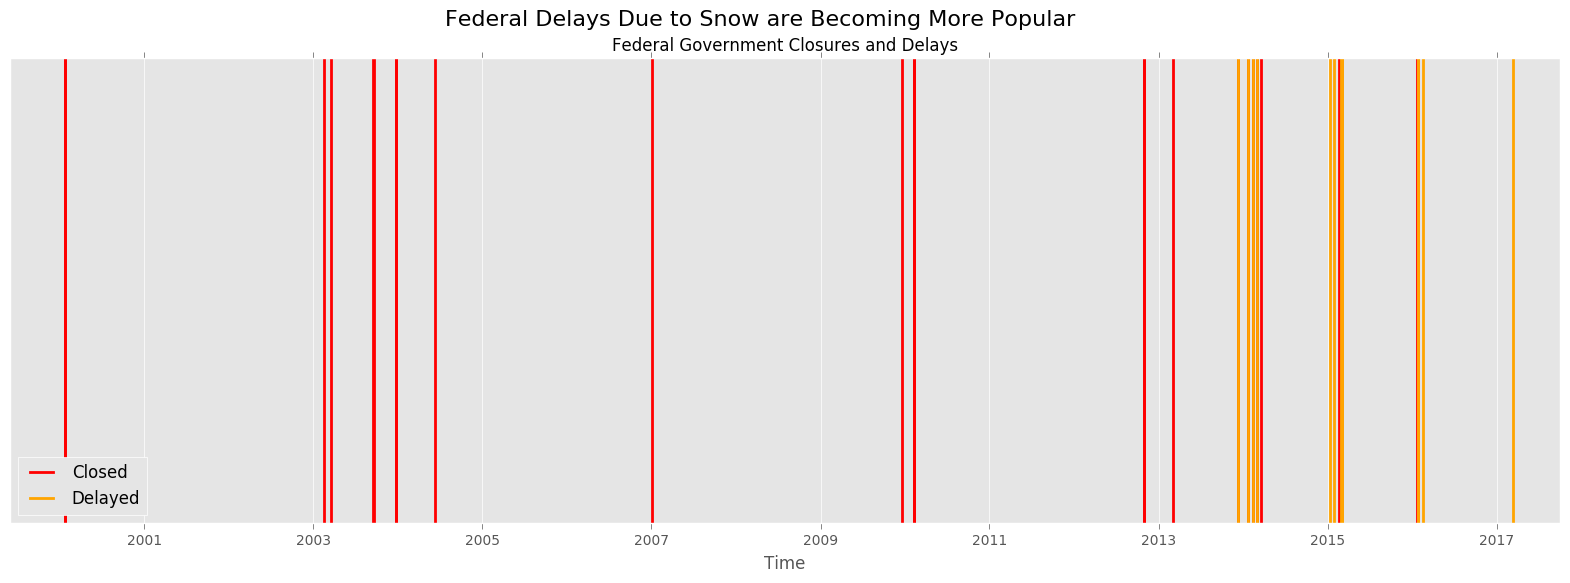

In [28]:
# plot closure/delays over time
fig, ax = plt.subplots()
plt.suptitle("Federal Delays Due to Snow are Becoming More Popular", size=16)
plt.title("Federal Government Closures and Delays", size=12)
plt.xlabel('Time')
ax.vlines(x=(opm_ts[opm_ts['closed'] == 1].index), ymin=0, ymax=1, color='red', linewidth=2, label='Closed')
ax.vlines(x=(opm_ts[opm_ts['delayed'] == 1].index), ymin=0, ymax=1, color='orange', linewidth=2, label='Delayed')
plt.xlim(['1999-06', '2017-10'])
plt.yticks([])
plt.ylabel('')
plt.legend(loc='lower left')
fig.set_size_inches(20, 6)
plt.savefig('./graphs/closures-delays.png', dpi=300, bbox_inches='tight')
plt.show()

## Google Search Volume Data

Read in the data, make a few plots.

In [29]:
# read in data
search = pd.read_csv('./google-trends-dc-snow.csv')
search.head()

,Week,snow: (District of Columbia)
0,3/25/12,3
1,4/1/12,3
2,4/8/12,3
3,4/15/12,3
4,4/22/12,4


In [30]:
# rename columns
search.rename(columns={'Week':'week', 'snow: (District of Columbia)':'volume'}, inplace=True)
search.head()

,week,volume
0,3/25/12,3
1,4/1/12,3
2,4/8/12,3
3,4/15/12,3
4,4/22/12,4


In [31]:
# format week column to datetime
search['week'] =  pd.to_datetime(search['week'])
# create timeseries
search_ts = search.set_index('week')

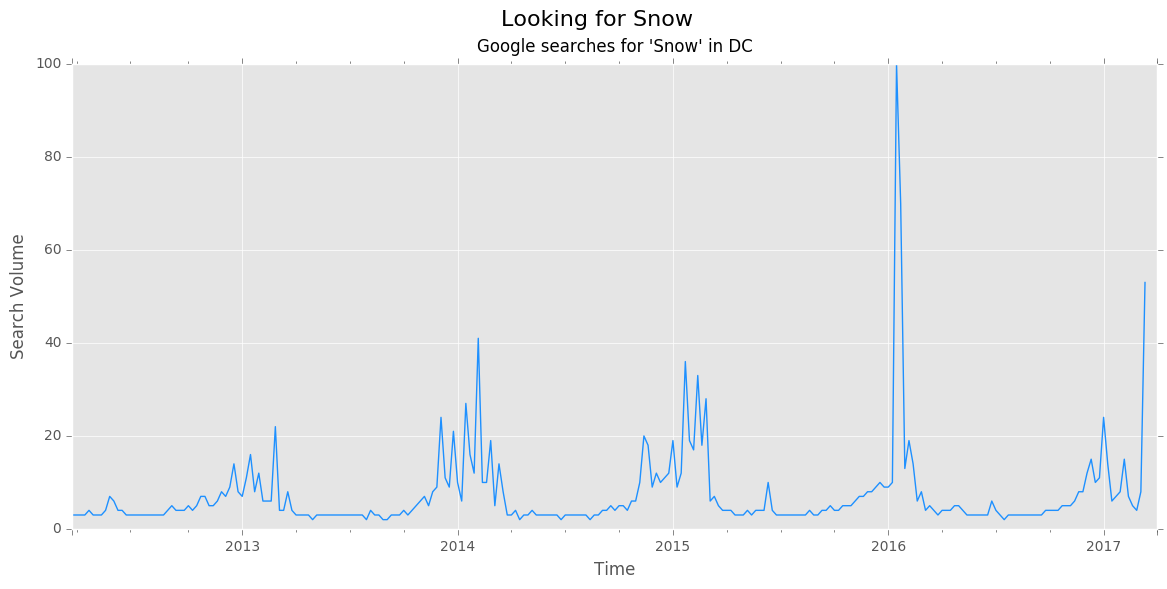

In [32]:
# plot it
search_ts.plot(color='dodgerblue', legend=None)
plt.suptitle("Looking for Snow", y=.99, size=16)
plt.title("Google searches for 'Snow' in DC", y=1.01, size=12)
plt.xlim([search_ts.index.min(), '2017-04'])
plt.xlabel('Time')
plt.ylabel('Search Volume')
plt.savefig('./graphs/snow-searches.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# earliest search data?
search_ts.index.min()

Timestamp('2012-03-25 00:00:00')

In [34]:
# get federal data to match
opm_ts_12 = opm_ts['2012-03-25':]

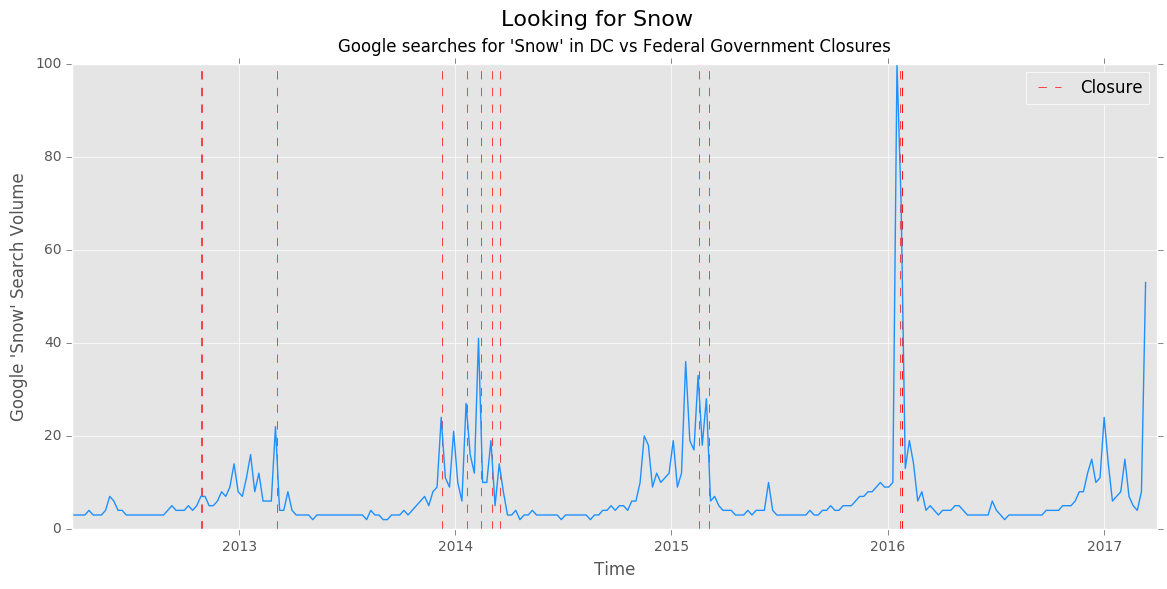

In [35]:
# plot snow searches vs snow closures
fig, ax = plt.subplots()
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=100, color='red', linestyles='dashed', linewidth=0.5, label='Closure')
ax.plot(search_ts, color='dodgerblue')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("Looking for Snow", y=.99, size=16)
plt.title("Google searches for 'Snow' in DC vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Google 'Snow' Search Volume")
plt.legend(loc='best')
#fig.set_size_inches(20, 6)
plt.savefig('./graphs/searches-vs-closures.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
search.head()

,week,volume
0,2012-03-25,3
1,2012-04-01,3
2,2012-04-08,3
3,2012-04-15,3
4,2012-04-22,4


## Historical Weather Forecast Data

Read in the data, make some plots

In [37]:
forecast = pd.read_csv('forecasts.csv')

In [38]:
# rid unnecessary column...
forecast.drop('Unnamed: 0', axis=1, inplace=True)

In [39]:
forecast.head()

,date,summary,temp,precip,precip_intensity,precip_type,wind,visibility
0,2012-03-25,Mostly Cloudy,58.18,0.0,0.0,NaN,3.05,9.42
1,2012-03-26,Clear,46.53,0.0,0.0,NaN,13.93,10.00
2,2012-03-27,Clear,46.92,0.0,0.0,NaN,6.93,10.00
3,2012-03-28,Partly Cloudy,65.16,0.0,0.0,NaN,5.92,10.00
4,2012-03-29,Clear,51.94,0.0,0.0,NaN,7.73,10.00


In [40]:
# make date a datetime object
forecast['date'] =  pd.to_datetime(forecast['date'])
# create timeseries
forecast_ts = forecast.set_index('date')

In [41]:
forecast_ts.head()

,summary,temp,precip,precip_intensity,precip_type,wind,visibility
date,,,,,,,
2012-03-25,Mostly Cloudy,58.18,0.0,0.0,NaN,3.05,9.42
2012-03-26,Clear,46.53,0.0,0.0,NaN,13.93,10.00
2012-03-27,Clear,46.92,0.0,0.0,NaN,6.93,10.00
2012-03-28,Partly Cloudy,65.16,0.0,0.0,NaN,5.92,10.00
2012-03-29,Clear,51.94,0.0,0.0,NaN,7.73,10.00


In [42]:
forecast_ts.describe(include='all')

,summary,temp,precip,precip_intensity,precip_type,wind,visibility
count,1820,1820.000000,1820.000000,1820.000000,269,1820.000000,1820.000000
unique,22,NaN,NaN,NaN,2,NaN,NaN
top,Clear,NaN,NaN,NaN,rain,NaN,NaN
freq,924,NaN,NaN,NaN,249,NaN,NaN
mean,NaN,56.222709,0.060797,0.004240,NaN,5.900527,9.348736
std,NaN,16.915543,0.182559,0.021823,NaN,3.422463,1.525629
min,NaN,10.350000,0.000000,0.000000,NaN,0.180000,0.380000
25%,NaN,42.607500,0.000000,0.000000,NaN,3.500000,9.510000
50%,NaN,57.515000,0.000000,0.000000,NaN,5.290000,10.000000
75%,NaN,71.235000,0.000000,0.000000,NaN,7.510000,10.000000


In [43]:
# DC, not a bad place to live
forecast_ts.summary.value_counts()

Clear                       924
Partly Cloudy               466
Mostly Cloudy               139
Overcast                     96
Light Rain                   91
Drizzle                      33
Rain                         31
Foggy                        10
Snow                          7
Light Snow                    6
Flurries                      4
Heavy Rain                    2
Breezy                        2
Windy and Mostly Cloudy       1
Dry                           1
Heavy Snow and Breezy         1
Snow and Breezy               1
Heavy Snow                    1
Light Rain and Breezy         1
Rain and Breezy               1
Heavy Rain and Windy          1
Breezy and Partly Cloudy      1
Name: summary, dtype: int64

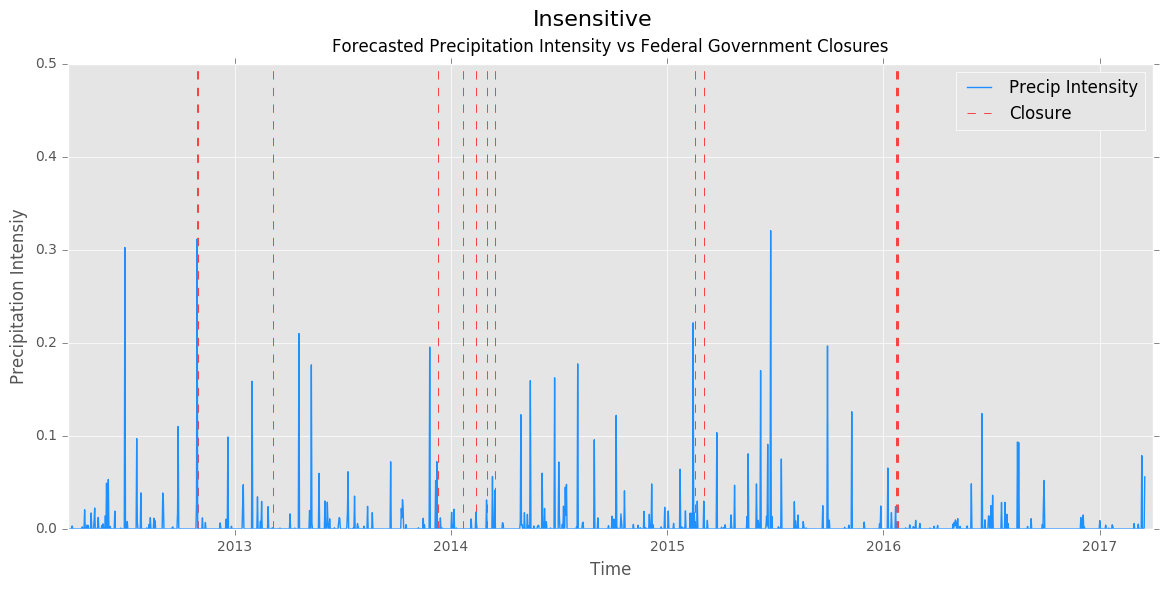

In [44]:
# plot 
fig, ax = plt.subplots()
ax.plot(forecast_ts.drop(['summary', 'temp', 'precip', 'precip_type','wind', 'visibility'], axis=1), color='dodgerblue', label='Precip Intensity')
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=.5, color='red', linestyles='dashed', linewidth=0.5, label='Closure')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("Insensitive", y=.99, size=16)
plt.title("Forecasted Precipitation Intensity vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Precipitation Intensiy")
plt.legend(loc='best')
plt.savefig('./graphs/precip_intensity_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()

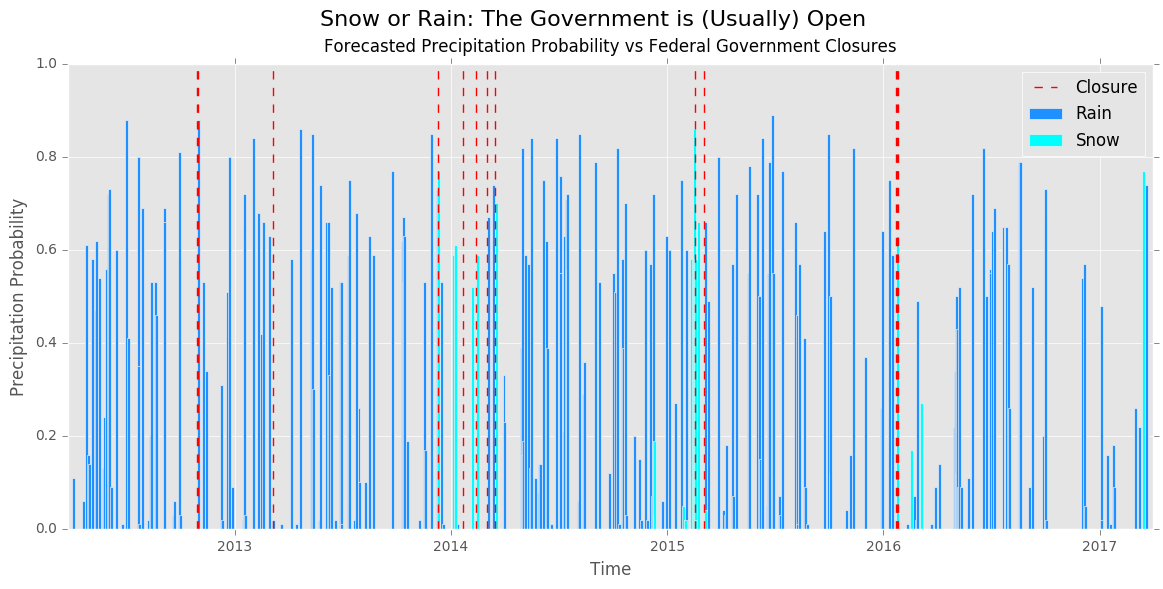

In [45]:
# rain and snow PROBABILITY vs closure
# thanks: http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html

fig, ax = plt.subplots()

# basics
width=5
x_rain = forecast_ts[forecast_ts.precip_type=='rain'].index
y_rain = forecast_ts[forecast_ts.precip_type=='rain'].precip
x_snow = forecast_ts[forecast_ts.precip_type=='snow'].index
y_snow = forecast_ts[forecast_ts.precip_type=='snow'].precip

## the bars
rain = ax.bar(x_rain, y_rain, width,color='dodgerblue', label = 'Rain')
snow = ax.bar(x_snow, y_snow, width, color='cyan', label = 'Snow')

#closure
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=1, color='red', linestyles='dashed', linewidth=1, label='Closure')

# set axes, title, and legend
ax.xaxis_date()
plt.xlim([search_ts.index.min(), '2017-04'])
plt.suptitle("Snow or Rain: The Government is (Usually) Open", y=.99, size=16)
plt.title("Forecasted Precipitation Probability vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Precipitation Probability")
plt.legend(loc='best')
plt.savefig('./graphs/precip_chance_type_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()



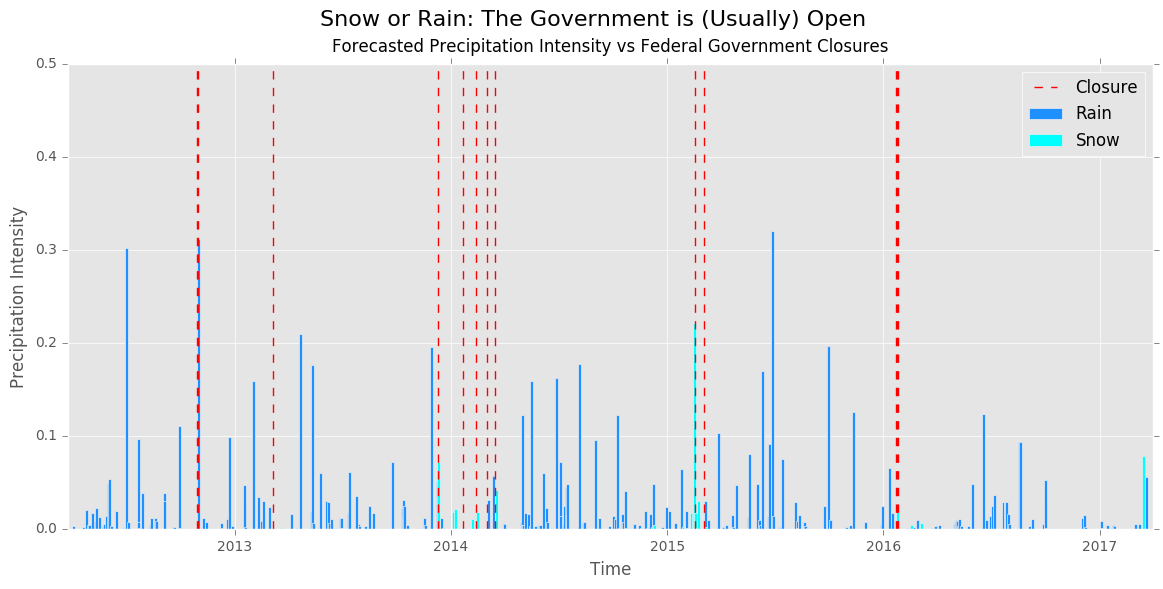

In [46]:
# combine the above two
# rain and snow INTENSITY vs closure
# thanks: http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html

fig, ax = plt.subplots()

# basics
width=5
x_rain = forecast_ts[forecast_ts.precip_type=='rain'].index
y_rain = forecast_ts[forecast_ts.precip_type=='rain'].precip_intensity
x_snow = forecast_ts[forecast_ts.precip_type=='snow'].index
y_snow = forecast_ts[forecast_ts.precip_type=='snow'].precip_intensity

## the bars
rain = ax.bar(x_rain, y_rain, width,color='dodgerblue', label = 'Rain')
snow = ax.bar(x_snow, y_snow, width, color='cyan', label = 'Snow')

#closure
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=.5, color='red', linestyles='dashed', linewidth=1, label='Closure')

# set axes, title, and legend
ax.xaxis_date()
plt.xlim([search_ts.index.min(), '2017-04'])
plt.suptitle("Snow or Rain: The Government is (Usually) Open", y=.99, size=16)
plt.title("Forecasted Precipitation Intensity vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Precipitation Intensity")
plt.legend(loc='best')
plt.savefig('./graphs/precip_intensity_type_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()



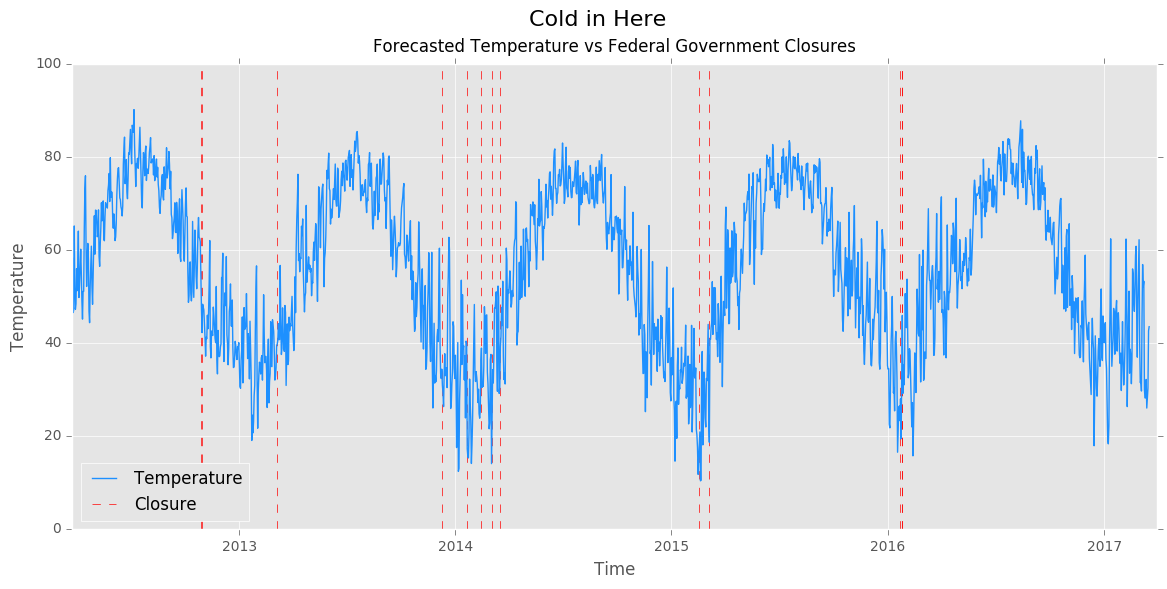

In [ ]:
# temperature vs closure?

fig, ax = plt.subplots()
ax.plot(forecast_ts.temp, color='dodgerblue', label='Temperature')
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=100, color='red', linestyles='dashed', linewidth=0.5, label='Closure')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("Cold in Here", y=.99, size=16)
plt.title("Forecasted Temperature vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.savefig('./graphs/temperature_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# temperature 10 day rolling average vs closure?

fig, ax = plt.subplots()
ax.plot(forecast_ts.temp.rolling(window=10,center=False).mean(), color='dodgerblue', label='Temperature')
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=100, color='red', linestyles='dashed', linewidth=0.5, label='Closure')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("No Chill", y=.99, size=16)
plt.title("Forecasted Temperature 10 Day Rolling Average vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.savefig('./graphs/temperature10day_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# wind rolling averagevs closure?

fig, ax = plt.subplots()
ax.plot(forecast_ts.wind.rolling(window=10,center=False).mean(), color='dodgerblue', label='Wind')
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=16, color='red', linestyles='dashed', linewidth=0.5, label='Closure')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("This Blows", y=.99, size=16)
plt.title("Forecasted Wind Speed 10 Day Rolling Average vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Wind Speed")
plt.legend(loc='best')
plt.savefig('./graphs/wind10day_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# visibility vs closure - looks cluttered

fig, ax = plt.subplots()

# basics
width=5
x_vis = forecast_ts[forecast_ts.visibility != 10].index
y_vis = forecast_ts[forecast_ts.visibility != 10].visibility

## the bars
ax.bar(x_vis, y_vis, width,color='dodgerblue', label = 'Visibility')

#closure
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=10, color='red', linestyles='dashed', linewidth=1, label='Closure')

# set axes, title, and legend
ax.xaxis_date()
plt.xlim([search_ts.index.min(), '2017-04'])
plt.suptitle("I Can See the Government is Open", y=.99, size=16)
plt.title("Forecasted Visibility vs Federal Government Closure", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Visibility in Miles")
plt.legend(loc='best')
plt.savefig('./graphs/visibility_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# rain and snow vs closure

fig, ax = plt.subplots()

# basics
width=5
x_vis = forecast_ts.visibility.index
y_vis = forecast_ts.visibility-10

## the bars
ax.bar(x_vis, y_vis, width,color='dodgerblue', label = 'Visibility')

#closure
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=-10, color='red', linestyles='dashed', linewidth=1, label='Closure')

# set x axis
ax.xaxis_date()
plt.xlim([search_ts.index.min(), '2017-04'])

# set y axis
labels = [0,2,4,6,8,10]
ax.set_yticklabels(labels)

# title and legend
plt.suptitle("I Can See the Government is Open", y=.99, size=16)
plt.title("Forecasted Visibility vs Federal Government Closure", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel("Visibility in Miles (Inverted)")
plt.legend(loc='best')
plt.savefig('./graphs/visibility_inverted_vs_closure.png', dpi=300, bbox_inches='tight')
plt.show()


# Model Prep

What is the most indicative feature of a federal government closure? Let's get our features ready.


**ASSUMPTIONS/LIMITATIONS**

- Because our Google search volume data is only available at the weekly level, we have no choice but to model at that unit of observation. This is clearly problematic: closure decisions are not made within the *week* of a forecast, but are instead made the day of. However, it is the best we can do.

- Second, because we only have forecast and search volume data going back to March 2012, we can only model the closures and/or delays that took place from March 2012 forward.



In [ ]:
# minimum and maximum dates?
print('Minimum forecast history', forecast.date.min(), 'Max forecast history', forecast.date.max())
print('Minimum search history', search.week.min(), 'Max search history', search.week.max())
print('Minimum OPM history', opm.clean_date.min(), 'Max OPM history', opm.clean_date.max())

In [ ]:
# create df that has our desire date range based on min/max of search data
dates = pd.Series(pd.date_range('2012-03-25', '2017-03-12'))

# create df with that Series - "clean date" because we'll merge OPM first
snow_fun = pd.DataFrame(dates, columns=['clean_date'])

In [ ]:
snow_fun.head()

In [ ]:
# add closures, delays, and both to df
snow_fun = pd.merge(snow_fun,opm[['clean_date','closed', 'delayed', 'delayed_or_closed']],on='clean_date', how='left')

In [ ]:
# check 'er out
snow_fun.head()

In [ ]:
# create a week column that is also just the clean date to merge search data
snow_fun['week'] = snow_fun['clean_date']

In [ ]:
# merge search data
snow_fun = pd.merge(snow_fun,search[['week', 'volume']],on='week', how='left')

In [ ]:
snow_fun.head()

In [ ]:
# time to add historical forecast data! We need a date column
snow_fun['date'] = snow_fun['clean_date']

In [ ]:
# merge weather data
snow_fun = pd.merge(snow_fun,forecast,on='date', how='left')

In [ ]:
# check out out new df
snow_fun.head()

In [ ]:
# set index as date
snow_fun.set_index('date', inplace=True)

In [ ]:
# no longer need our join keys
snow_fun.drop(['clean_date', 'week'], axis=1, inplace=True)

In [ ]:
# make datetime object
snow_fun.index = pd.to_datetime(snow_fun.index)

In [ ]:
# make a feature for months
snow_fun['month'] = snow_fun.index.month

In [ ]:
snow_fun.head()

In [ ]:
# prepare data dataframe by week given stated assumptions above - average these features
# thanks http://stackoverflow.com/questions/24082784/pandas-dataframe-groupby-datetime-month
averages = ['volume', 'temp', 'precip', 'precip_intensity', 'precip_type', 'wind', 'visibility']
X = pd.DataFrame(snow_fun[averages].groupby(pd.TimeGrouper(freq='W')).mean())

In [ ]:
# add months to this df - do not average month across weeks
X['month'] = snow_fun.groupby(pd.TimeGrouper(freq='W')).month.max()

In [ ]:
# our y is equal to 1 if there was a closure in a given week else it's zero
y = [1 if val == 1 else 0 for val in snow_fun.groupby(pd.TimeGrouper(freq='W')).closed.max().values]

In [ ]:
# does it all check out? (Yes. It's go time.)
print(X.shape)
print(len(y))

# Model Building

First, I'll use a logistic regression to see classify whether a given week will include a closure. I'll use both sklearn and statsmodels.

I'm also going to use a random forest to classify these estimates. They're traditionally strong ensembling models, and they will enable me to evaluate feature importances. In addition, random forest are known to even rival ARIMA models when handling time data.

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
rf_grid = RandomForestClassifier(random_state=99, n_jobs=50)
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import statsmodels.formula.api as sm

In [ ]:
# create generic data df using prepped data above
data = X
data['target'] = y

In [ ]:
# important note: severely imbalanced classes :(
data.target.value_counts()

In [ ]:
# train, test, split and use stratification
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], 
                                                    test_size=0.33, stratify=data['target'].values, random_state=42)

In [ ]:
# calculate null accuracy
y_test_binary = np.where(y_test==0, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

### Logistic Regression

In [ ]:
# using a plain logistic regression predicts open every day - our null accuracy (or worse)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print acc

In [ ]:
# set up a different model to grid search
logreg = LogisticRegression()
c_range = 10.**np.arange(-2, 3)
penalties = ['l1','l2']

In [ ]:
# gridsearch across options
# optimize for log loss: http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/
gs = GridSearchCV(logreg, {'penalty':penalties, 'C':c_range}, verbose=True, cv=5, scoring='log_loss')
gs.fit(X, y)

In [ ]:
# best parameters?
gs.best_params_

In [ ]:
# use these params
logreg = LogisticRegression(penalty = 'l1', C = 100)

In [ ]:
# fit it
logreg.fit(X_train, y_train)

In [ ]:
# predict with these params
y_pred = logreg.predict(X_test)

In [ ]:
# roc_auc?
roc_auc_score(y_test, y_pred)

In [ ]:
# accuracy?
accuracy_score(y_test, y_pred)

In [ ]:
# coefficients?
logreg.coef_

In [ ]:
# get a report in statsmodels using regularization
model = sm.logit("target ~ volume + temp + precip + precip_intensity + wind + visibility + month", data=data).fit_regularized(method='l1', alpha=0.01)
model.summary()

In [ ]:
# fit a regular logistic regression in statsmodels just to see variable importances
model = sm.logit("target ~ volume + temp + precip + precip_intensity + wind + visibility + month", data=data).fit()
model.summary()

### Interaction Terms

Temp x precip, temp x precip_intensity, temp x volume, wind x precip

In [ ]:
# create interaction terms
X['temp_precip'] = X['temp'] * X['precip']
X['temp_precip_intensity'] = X['temp'] * X['precip_intensity']
X['temp_volume'] = X['temp'] * X['volume']
X['wind_precip'] = X['wind'] * X['precip']
X['wind_precip_intensity'] = X['wind'] * X['precip_intensity']
X['wind_volume'] = X['wind'] * X['volume']

In [ ]:
model = sm.logit("target ~ volume + temp + precip + precip_intensity + wind + visibility + month + temp_precip + temp_precip_intensity + temp_volume + wind_precip + wind_precip_intensity + wind_volume", data=data).fit()
model.summary()

With all interaction terms available, it appears precipitation is *only* signifiant when wind is also anticipated. Wind and preciptation together represent a significant factor, but wind alone is not.

Aside from the interactions, it appears we only need to use the forecasted average weekly temperature to determine with a high degree accuracy whether OPM is going to close the federal government or not.

In [ ]:
# non-interaction features
features = ['volume', 'temp', 'precip', 'precip_intensity', 'wind', 'visibility', 'month']

In [ ]:
# gridsearch across options for PRECISION - only predicting snow days when they happen
# what if I optimize for precision?
gs = GridSearchCV(logreg, {'penalty':penalties, 'C':c_range}, verbose=True, cv=5, scoring='precision')
gs.fit(X[features], y)

In [ ]:
# best parameters?
gs.best_params_

In [ ]:
# use these params
logreg = LogisticRegression(penalty = 'l1', C = 1)

In [ ]:
# fit it
logreg.fit(X_train, y_train)

In [ ]:
# roc_auc?
roc_auc_score(y_test, y_pred)

In [ ]:
# accuracy?
accuracy_score(y_test, y_pred)

In [ ]:
# coefficients?
coefs = pd.DataFrame(logreg.coef_, columns = features)
coefs.head()

### Random Forest

In [ ]:
#Parameter dictionary of settings options for the model we're passing grid search.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [None,2,5,8],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', None]
}

In [ ]:
#Instantiate grid search.
grid = GridSearchCV(rf_grid, param_grid, cv=5, scoring='roc_auc')

# Overfit the grid search to X and y.
grid.fit(X[features], y)

In [ ]:
#Store the best parameters in a variable.
params = grid.best_params_
print "Best score =", grid.best_score_
print params

In [ ]:
#Run Random Forest on the data.
rf = RandomForestClassifier(**params)
rf_model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print "RandomForest Cross_Val Score:\t", cross_val_score(rf, X_train, y_train, cv=5).mean()
print "Train/Test RandomForest Score:\t", rf.score(X_test, y_test)

In [ ]:
# create dataframe showing feature importances of rf
df_features = pd.DataFrame(columns=['Features', 'Importance (Gini Index)'])
df_features['Features'] = columns=features
df_features['Importance (Gini Index)'] = rf.feature_importances_
df_features.sort_values('Importance (Gini Index)', ascending=False, inplace=True)

In [ ]:
df_features.head(10)

In [ ]:
# feature importances determining closure

fig, ax = plt.subplots()
ind = np.arange(len(df_features.index))

# basics
width=0.5
x = ind
y = df_features['Importance (Gini Index)'].values

## the bars
ax.bar(x, y, width,color='dodgerblue', label = 'Importance (Gini Index)')

# handle axes and ticks
ax.set_ylabel('Gini Index')
ax.set_xticks(ind + width / 2)
plt.xlabel('Factor')
ax.set_xticklabels(('Temperature', 'Wind', 'Visibility', "Google Searches \nfor 'Snow'", 'Month', 'Precipitation \nIntensity', 'Precipitation'))

# title, size, and legend
plt.suptitle("Colds Weather Determines Federal Closures", y=.99, size=16)
plt.title("The Most Important Factors in OPM's Decisions to Close the Federal Government", y=1.01, size=12)
plt.rcParams['figure.figsize'] = (12, 6)
plt.legend(loc='best')
plt.savefig('./graphs/rf_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()


Our logistic regressions and random forests confirm: OPM most relies on temperature in their decision to close the federal government. In fact, we can reject at the 5% significance level that Google searches for "Snow" play a factor in their decision-making.

Nonetheless, even our regularized models kept Google searches for snow as a term. Keep Googling for that Snow, DC.